In [5]:
%matplotlib inline
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K

Using TensorFlow backend.


In [7]:
import sys
#sys.path.append('/usr/local/opt/opencv/lib/python2.7/site-packages/')
from glob import glob
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
from numpy.linalg import inv

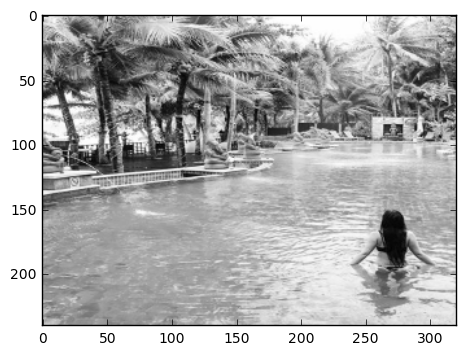

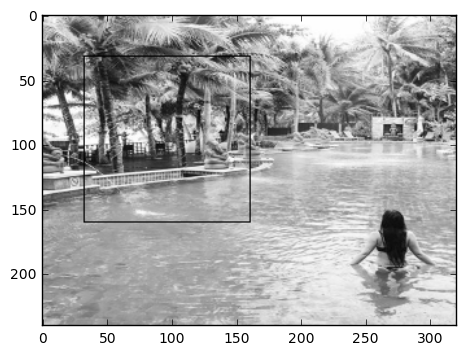

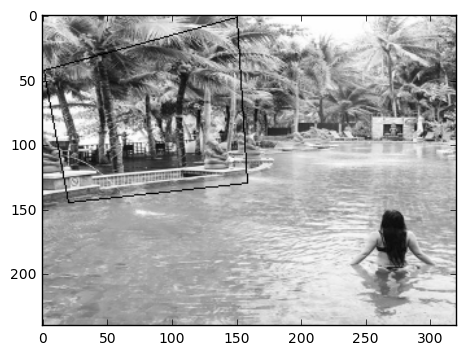

In [12]:
test_image = plt.imread('21910795_272022839968742_1888238507185405952_n.jpg')
test_image = cv2.resize(test_image, (320, 240))
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
plt.imshow(test_image, cmap='gray')
plt.show()

rho          = 32
patch_size   = 128

top_point    = (32,32)
left_point   = (patch_size+32, 32)
bottom_point = (patch_size+32, patch_size+32)
right_point  = (32, patch_size+32)

annotated_image = test_image.copy()
H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
print(H)
four_points = [top_point, left_point, bottom_point, right_point]

cv2.polylines(annotated_image, np.int32([four_points]), 1, (0,0,0))
plt.imshow(annotated_image, cmap='gray')
plt.show()

perturbed_four_points = []
for point in four_points:
    perturbed_four_points.append((point[0] + random.randint(-rho,rho), point[1]+random.randint(-rho,rho)))

perturbed_annotated_image = test_image.copy()
cv2.polylines(perturbed_annotated_image, np.int32([perturbed_four_points]), 1, (0,0,0))
plt.imshow(perturbed_annotated_image, cmap='gray')
plt.show()

In [15]:
H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
print(H)
H_inverse = inv(H)
print(H_inverse)

[[  9.15254891e-01   1.58606720e-01  -3.33883443e+01]
 [ -3.15310414e-01   8.77520804e-01   2.39440385e+01]
 [ -1.46647039e-03   6.92321402e-04   1.00000000e+00]]
[[  1.08057409e+00  -2.28080251e-01   4.15397422e+01]
 [  3.51676628e-01   1.08728644e+00  -1.42921280e+01]
 [  1.34115666e-03  -1.08722461e-03   1.07081155e+00]]


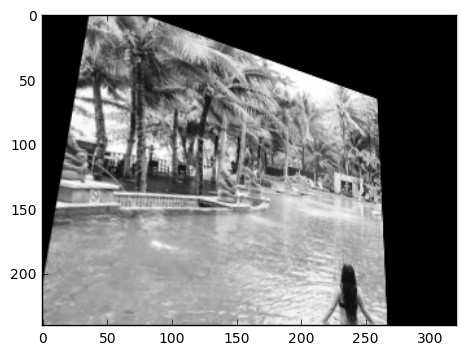

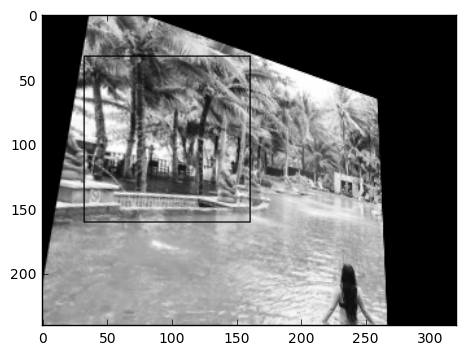

In [17]:
warped_image = cv2.warpPerspective(test_image,H_inverse, (320,240))
plt.imshow(warped_image, cmap='gray')
plt.show()

annotated_warp_image = warped_image.copy()
cv2.polylines(annotated_warp_image, np.int32([four_points]), 1, (0,0,0))
plt.imshow(annotated_warp_image, cmap='gray')
plt.show()

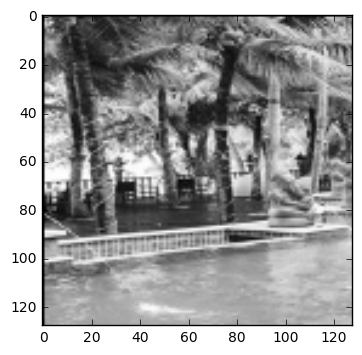

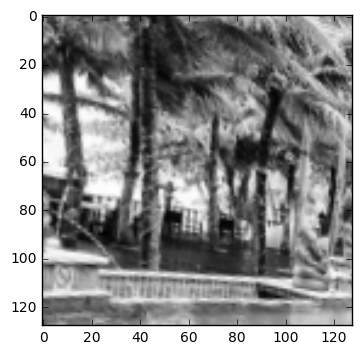

In [18]:
Ip1 = annotated_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]
Ip2 = warped_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]

plt.imshow(Ip1, cmap='gray')
plt.show()

plt.imshow(Ip2, cmap='gray')
plt.show()

In [20]:
training_image = np.dstack((Ip1, Ip2))
print(training_image.shape)

H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
print(H_four_points)

(128, 128, 2)
[[-31  11]
 [-10 -30]
 [ -2 -30]
 [-12 -15]]


In [47]:
def euclidian_distance(y_true, y_pred):
    return K.sqrt(K.maximum(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True),K.epsilon()))
    
def homography_regression_model():
    input_shape=(128, 128, 2)
    input_image = Input(shape=input_shape)
    #K.backend.cast_to_tensor(input_img)
    x = Conv2D(64,(3,3),padding='same',strides=(1,1),activation='relu',name='conv1')(input_image)
    x = Conv2D(64,(3,3),padding='same',strides=(1,1),activation='relu',name='conv2')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool1')(x)
    
    x = Conv2D(64,(3,3),padding='same',strides=(1,1),activation='relu',name='conv3')(x)
    x = Conv2D(64,(3,3),padding='same',strides=(1,1),activation='relu',name='conv4')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool2')(x)
    
    x = Conv2D(128,(3,3),padding='same',strides=(1,1),activation='relu',name='conv5')(x)
    x = Conv2D(128,(3,3),padding='same',strides=(1,1),activation='relu',name='conv6')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='pool3')(x)
    
    x = Conv2D(128,(3,3),padding='same',strides=(1,1),activation='relu',name='conv7')(x)
    x = Conv2D(128,(3,3),padding='same',strides=(1,1),activation='relu',name='conv8')(x)
    x = Flatten()(x)
    
    x = Dense(1024, name='FC1')(x)
    out = Dense(8, name='loss')(x)
    
    model = Model(input=input_image, output=[out])
    #plot_model(model, to_file='homographynet.png', show_shapes=True)
    
    model.compile(optimizer=Adam(lr=1e-3), loss=euclidian_distance)
    
    return model

In [48]:
model = homography_regression_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 2)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1216      
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 64)        36928     
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 64, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 64)        0         
__________

/Users/dmitriykhvan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
